## Don't Get Kicked!

The challenge is to predict if a car purchased at the Auction is a Kick (bad buy).

- ** Software and Libraries**

This project uses the following software and Python libraries:

- Python 3.5
- Numpy
- Pandas
- sklearn
- matplotlib
- seaborn
- scipy
- Jupyter Notebook

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./training.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72983 non-null int64
IsBadBuy                             72983 non-null int64
PurchDate                            72983 non-null object
Auction                              72983 non-null object
VehYear                              72983 non-null int64
VehicleAge                           72983 non-null int64
Make                                 72983 non-null object
Model                                72983 non-null object
Trim                                 70623 non-null object
SubModel                             72975 non-null object
Color                                72975 non-null object
Transmission                         72974 non-null object
WheelTypeID                          69814 non-null float64
WheelType                            69809 non-null object
VehOdo                               72983 non-null int64
Nationalit

### Train-Test Split

The data is split into train and test datasets in a stratified fashion using the target label. The training dataset includes 75% of the original dataset. 

In [3]:
from sklearn.cross_validation import train_test_split

y = df['IsBadBuy']
X = df.drop('IsBadBuy',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 33) 

### Feature Engineering:

The number of missing values in each column of the training and test datasets are as follows:

In [4]:
print ('Shape of X_train is: (%i,%i) \n' % X_train.shape)
X_train.isnull().sum()

Shape of X_train is: (54737,33) 



RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1757
SubModel                                 5
Color                                    5
Transmission                             6
WheelTypeID                           2398
WheelType                             2402
VehOdo                                   0
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice       11
MMRAcquisitionAuctionCleanPrice         11
MMRAcquisitionRetailAveragePrice        11
MMRAcquisitonRetailCleanPrice           11
MMRCurrentAuctionAveragePrice          234
MMRCurrentAuctionCleanPrice            234
MMRCurrentR

In [5]:
print ('Shape of X_test is: (%i,%i) \n' % X_test.shape)
X_test.isnull().sum()

Shape of X_test is: (18246,33) 



RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                   603
SubModel                                 3
Color                                    3
Transmission                             3
WheelTypeID                            771
WheelType                              772
VehOdo                                   0
Nationality                              1
Size                                     1
TopThreeAmericanName                     1
MMRAcquisitionAuctionAveragePrice        7
MMRAcquisitionAuctionCleanPrice          7
MMRAcquisitionRetailAveragePrice         7
MMRAcquisitonRetailCleanPrice            7
MMRCurrentAuctionAveragePrice           81
MMRCurrentAuctionCleanPrice             81
MMRCurrentR

#### Notes:

1. About 95% of data is missing in `PRIMEUNIT` and `AUCGUART` columns. Therefore, they are removed from datasets.
2. The missing values in `Transmission` are replaced with the most frequent category i.e. 'AUTO'.
3. The missing values in `Color` are replaced with 'NOT AVAIL' which is one of the existing labels for color.
4. The missing values of `SubModel` in the training dataset are removed. The only missing value in the test dataset is replaced with 'Unknown'.
5. The missing values of `Size` are found using the information in the test dataset based on `Make` and `Model` of the vehicle. 
6. The missing values of `Nationality` and `TopThreeAmericanName` are found using the information in the test dataset. 
7. The missing values of `WheelTypeID` are replaced with 0.0, which already exist for some samples with missing `WheelType`. Additionally, `WheelType` is redundant and is removed from the dataset. 
8. The possible options for `Trim` are found using the `Make`, `Model`, and `SubModel` in the training dataset. Then the most frequent trim type is assigned to the missing values.
9. To fill in the missing values in acquisition prices, the prices for similar vehicles are found using `Make`, `Model`, `VehicleAge`, and `Size` information in the training dataset. Then the missing values are replaced with the median value of the matching vehicle type. 


In [6]:
# Remove 'PRIMEUNIT' and 'AUCGUART'.
X_train = X_train.drop(['PRIMEUNIT','AUCGUART'],axis=1)
X_test = X_test.drop(['PRIMEUNIT','AUCGUART'],axis=1)


# Convert purchase date to int type
for dfn in [X_train, X_test]:
    dfn.PurchDate = pd.to_datetime(dfn.PurchDate,format=r'%m/%d/%Y').astype(np.int64)//10**10

    
# Replace missing values in Transmission with Auto and Color to 'NOT AVAIL'
def singleValueImputer(df,colname,val):
    '''Converts all strings to uppercase and replaces na with val'''
    df[colname] = df[colname].str.upper()
    df[colname] = df[colname].fillna(val)
    return df

impute_list = [('Transmission','AUTO'),('Color','NOT AVAIL')]

for t in impute_list:
    X_train = singleValueImputer(X_train,t[0],t[1])
    X_test = singleValueImputer(X_test,t[0],t[1])


# Remove samples with missing values in SubModel
mask_train = X_train.SubModel.notnull()
X_train = X_train.loc[mask_train,:].copy()
X_test.SubModel.fillna('Unknown',inplace=True)
y_train = y_train[mask_train].copy()


# Impute size
def imputeSize(df,df_train):
    '''Finds the Size using Make and Model in training data otherwise "unknown"'''
    S = df.loc[df.Size.isnull(),['Make','Model']]
    for index , make , model in S.itertuples():
        size = df_train.loc[((df_train.Make==make) & (df_train.Model==model) & df_train.Size.notnull()),'Size'].unique()
        if len(size)==1:
            df.loc[int(index),'Size'] = size[0]
        else:
            df.loc[int(index),'Size'] = 'Unknown'
    return df

X_train = imputeSize(X_train,X_train)
X_test = imputeSize(X_test,X_train)


# Impute Nationality and TopThreeAmericanName
def imputeNationality_Top3(df,df_train,colname):
    '''Only use for Nationality and TopThreeAmericanName'''
    S = df.loc[df[colname].isnull(),['Make']]
    for index, make in S.itertuples():
        name = df_train.loc[(df_train[colname].notnull() & (df_train.Make==make)), colname].unique()[0]
        if name:
            df.loc[int(index),colname] = name
    return df

impute_list = ['Nationality','TopThreeAmericanName']
for name in impute_list:
    X_train = imputeNationality_Top3(X_train,X_train,name)
    X_test = imputeNationality_Top3(X_test,X_train,name)

    
# Impute WheelType and remove WheelTypeID
for dfn in [X_train,X_test]:
    dfn.WheelTypeID.fillna(0.0,inplace=True)
    dfn.drop('WheelType',axis=1, inplace=True)

# Impute Trim using the information from Make, Model, and SubModel.
def imputeTrim(df,df_train):
    '''Imputes the missing values int the Trim column'''
    S = df.loc[df.Trim.isnull(),['Make','Model','SubModel']]
    for index, make, model, submodel in S.itertuples():
        trims = (df_train.loc[(df_train.Make==make) & (df_train.Model==model) & (df_train.SubModel==submodel) &
                              (df_train.Trim.notnull()),'Trim']).value_counts()
        if len(trims) > 0:
            df.loc[int(index),'Trim'] = trims.argmax()
        else:
            df.loc[int(index),'Trim'] = 'Unknown'
    return df

for dfn in [X_train,X_test]:
    dfn = imputeTrim(dfn,X_train)

    
# Impute missing prices
def imputeMMR(df,df_train,colname):
    '''Imputes the missing values of Acquisition prices'''
    S = df.loc[df[colname].isnull(),['Make','Model','VehicleAge','Size']]
    for index, make, model, age, size in S.itertuples():
        val = df_train.loc[(df_train.Make==make) & (df_train.Model==model) & (df_train[colname].notnull()) &
                           (df_train.VehicleAge==age),colname].quantile()
        if np.isfinite(val):
            df.loc[int(index),colname] = val
        else:
            val = df_train.loc[(df_train.Make==make) & (df_train.Size==size) & (df_train[colname].notnull()) 
                               & (df_train.VehicleAge==age),colname].quantile()
            df.loc[int(index),colname] = val
    return df 

colnames = ['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice',
           'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice',
           'MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice']
for colname in colnames:
    X_train = imputeMMR(X_train,X_train,colname)
    X_test = imputeMMR(X_test,X_train,colname)

In [7]:
# drop the last missing row in the training data
mask = X_train.MMRCurrentAuctionCleanPrice.notnull()
X_train = X_train.loc[mask,:]
y_train = y_train[mask]

In [8]:
print ('Is there any null value in the training dataset?   %s' % (X_test.isnull().any()).any())
print ('Is there any null value in the test dataset?       %s' % (X_test.isnull().any()).any())

Is there any null value in the training dataset?   False
Is there any null value in the test dataset?       False


### Data Exploration

The following pie chart shows that the dataset is imbalanced and the prevalence of the majority class is 87.7%.

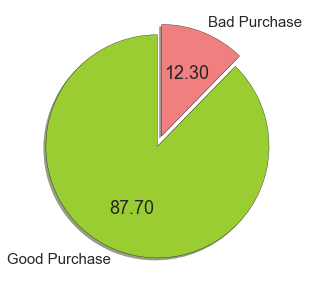

In [9]:
sns.set_context('notebook',font_scale=1.5)
labels =['Good Purchase','Bad Purchase']
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1)
plt.figure(figsize=(5,5))
plt.pie(y_train.value_counts(),labels=labels,colors=colors,explode=explode, shadow=True, startangle=90, autopct='%.2f');

In [10]:
sns.set(font_scale=1.25)
plt.rcParams['figure.figsize']=(14,5);
def crosstab_barplot(df,target,feature,plot_type='count',verbose = False,log_scale = False):
    '''Plots a bar chart for the given feature. The bar chart could be in the type of 
    "count value" and "percentage". It is also possible to plot in log-scale '''
    ctab = pd.crosstab(df[feature],target.astype(bool))
    if verbose:
        print (ctab)
    if plot_type == 'count':
        ctab.plot.bar(log=log_scale)
        plt.ylabel('Count');
    elif plot_type == 'percentage':
        s = ctab.iloc[:,1]/ctab.sum(axis=1)*100
        df = pd.DataFrame([s,100-s],index=['True','Flase']).transpose()
        df.plot.bar(log=log_scale)
        plt.ylabel('Percentage')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, title=ctab.columns.name)
    plt.title(feature + ' vs Purchase Result')
    
    return ctab

In [11]:
colors = ['yellowgreen', 'lightcoral']
def plotPieChart(df,target,feature,figsize,c,nrows=1,ncols=2,txt=''):
    '''Plots pie charts for a given feature'''
    ctab = pd.crosstab(df[feature],target.astype(bool))
    m,n = ctab.shape
    plt.figure()
    labels =['Good Purchase','Bad Purchase']
    colors = c
    explode = (0, 0.1)
    plt.figure(figsize=figsize)
    for i in range(m):
        plt.subplot(nrows,ncols,i+1)
        plt.title(str(ctab.index[i])+txt)
        plt.pie(ctab.iloc[i,:],labels=labels,colors=colors,explode=explode, shadow=True, startangle=90, autopct='%.2f');
    plt.suptitle(feature + ' vs Purchase Result', y=1.05);
    return ctab

The following bar chart and table show that the purchased vehicles from specific brands such as `Volvo` were mostly a kick! However, it should be considered that the number of vehicles purchased varies considerably among different brands. 

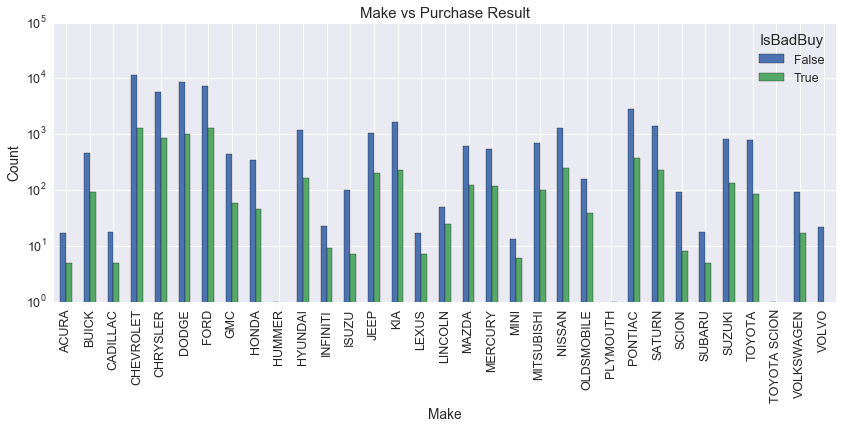

In [12]:
ctab = crosstab_barplot(X_train,y_train,'Make',log_scale=True)

In [13]:
# value count of targets fot each beand ('Make')
print(ctab)

IsBadBuy      False  True 
Make                      
ACURA            17      5
BUICK           455     91
CADILLAC         18      5
CHEVROLET     11672   1273
CHRYSLER       5775    844
DODGE          8682    997
FORD           7148   1308
GMC             434     58
HONDA           339     45
HUMMER            1      0
HYUNDAI        1189    163
INFINITI         23      9
ISUZU           101      7
JEEP           1070    198
KIA            1655    224
LEXUS            17      7
LINCOLN          50     25
MAZDA           615    121
MERCURY         551    117
MINI             13      6
MITSUBISHI      691     99
NISSAN         1301    243
OLDSMOBILE      158     38
PLYMOUTH          0      1
PONTIAC        2805    367
SATURN         1401    230
SCION            92      8
SUBARU           18      5
SUZUKI          821    135
TOYOTA          774     85
TOYOTA SCION      1      0
VOLKSWAGEN       91     17
VOLVO            22      0


The following pie chart shows that Older vehicles are more likely to be a kicked car. 

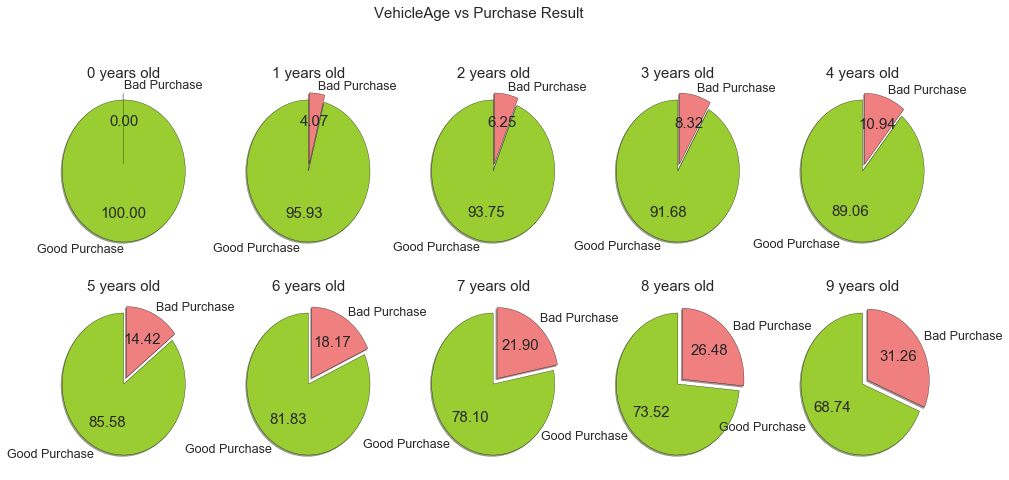

In [14]:
Ctab = plotPieChart(X_train,y_train,'VehicleAge',(16,7),colors,nrows=2,ncols=5,txt=' years old')

There is no significant correlation between the types of `Transmission`, `Nationality`, `TopThreeAmericanName` and `Size` of the vehicles with a higher risk of being a kick vehicle. Therefore, these features do not seem to provide useful information for predicting the desired target.

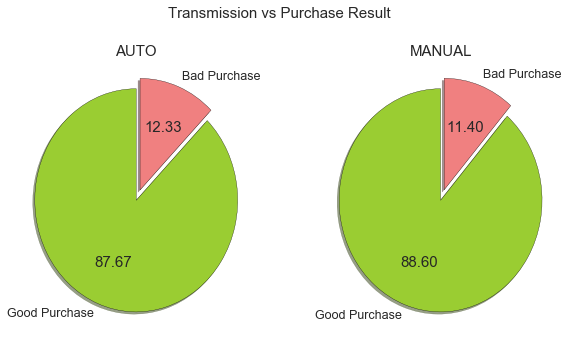

In [15]:
Ctab = plotPieChart(X_train,y_train,'Transmission',(10,5),colors)

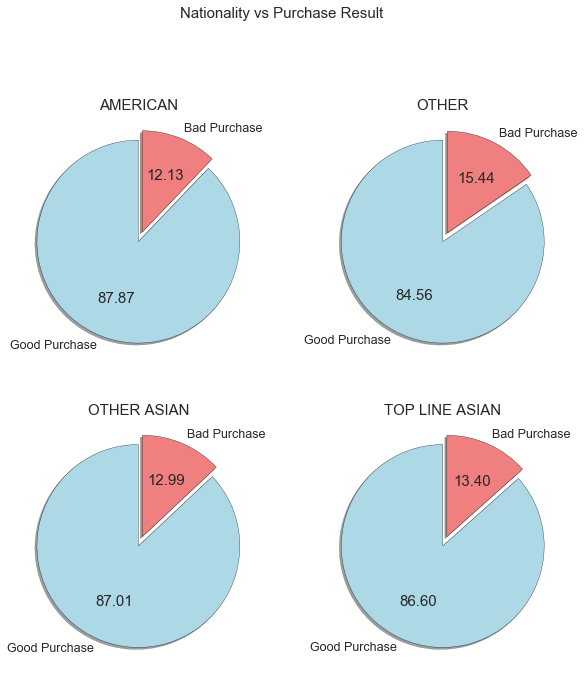

In [16]:
colors = ['lightblue', 'lightcoral']
Ctab = plotPieChart(X_train,y_train,'Nationality',(10,10),colors,nrows=2,ncols=2)

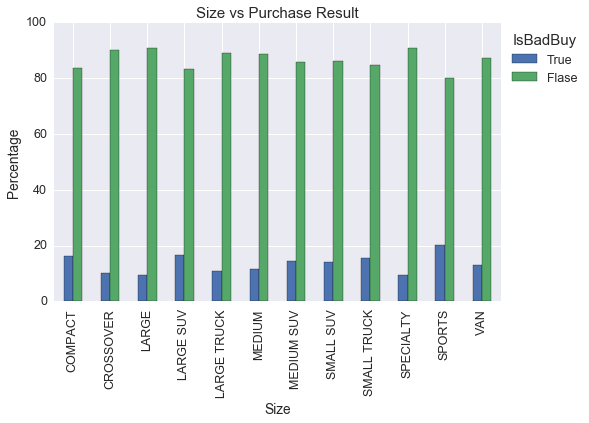

In [17]:
plt.rcParams['figure.figsize']=(8,5);
Ctab = crosstab_barplot(X_train,y_train,'Size',plot_type='percentage')

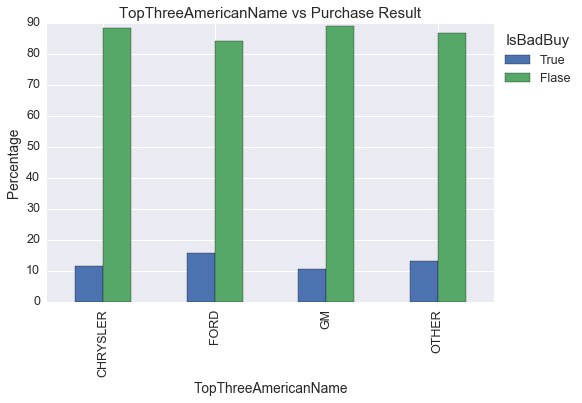

In [18]:
Ctab = crosstab_barplot(X_train,y_train,'TopThreeAmericanName',plot_type='percentage')

### Encoding Categorical Data

The categorical variables must be encoded to numerical values before using sklean estimators. I used two types of encoding approaches:

1. Encoding using sklearn.preprocessing.LableEncoder()
2. Encoding using pandas.get_dummies()


**Challenges:**

In comparison with *one-hot encoding*, a simple LableEncoding leads to a less sparse data frame which is memory efficient. However, this form of encoding is not suitable when a linear estimator is used for modeling. Additionally, all the labels should exist in the training dataset, otherwise, it raises an error upon applying the encoder to the test dataset.

Pandas.get_dummies is similar to OneHotEncoder of sklearn. It can be easily applied to both train and test datasets. In the case of encountering an unseen label in the test dataset, we can be easily reset the indices the labels of the training data set.  

I am going to use a `RandomForestClassifier`. Therefore, I do not necessarily need to convert the data to a one-hot encoded form. However, as some unseen labels exist in the test set, a pandas.get_dummies is used for those columns.   

In [19]:
from collections import defaultdict

encoders = defaultdict(str)

def labelEncoder(df_train, df_test, colnames, encoders):
    '''This function uses the sklean encoders to convert categorical variables to
    integers between 0 and n_class-1. The encoders for features are collected in a 
    dictionary. 
    Note: All labels in test dataset must exist in training dataset.'''
    for colname in colnames:
        from sklearn.preprocessing import LabelEncoder
        encoders[colname] = LabelEncoder()
        encoders[colname].fit(df_train[colname])
        df_train[colname] = encoders[colname].transform(df_train[colname])
        df_test[colname] = encoders[colname].transform(df_test[colname])
    return df_train, df_test, encoders

columns = ['Auction', 'Make', 'Color', 'Transmission', 'Nationality',
            'Size', 'TopThreeAmericanName', 'VNST']

X_train, X_test, encoders = labelEncoder(X_train,X_test,columns,encoders)

In [20]:
encoders['Make'].classes_

array(['ACURA', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE',
       'FORD', 'GMC', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI', 'ISUZU',
       'JEEP', 'KIA', 'LEXUS', 'LINCOLN', 'MAZDA', 'MERCURY', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OLDSMOBILE', 'PLYMOUTH', 'PONTIAC',
       'SATURN', 'SCION', 'SUBARU', 'SUZUKI', 'TOYOTA', 'TOYOTA SCION',
       'VOLKSWAGEN', 'VOLVO'], dtype=object)

In [21]:
columns = ['Model', 'SubModel', 'Trim']

def dummyEncoder(df_train, df_test, columns):
    '''OneHotEndoding of the categorical variables. This function resets labels  
    to those that were observed in the training data set'''
    for colname in columns:
        dummies_train = pd.get_dummies(df_train[colname])
        df_train = pd.concat([df_train, dummies_train], axis=1)
        df_train.drop(colname, axis=1, inplace=True)
        dummies_test = pd.get_dummies(df_test[colname])
        dummies_test = dummies_test.reindex(columns=dummies_train.columns, fill_value=0)
        df_test = pd.concat([df_test, dummies_test], axis=1)
        df_test.drop(colname, axis=1, inplace=True)
    return df_train, df_test

X_train, X_test = dummyEncoder(X_train, X_test, columns) 

In [22]:
print ('Shape of the training data set; ', X_train.shape)
print ('Shape of the test data set; ', X_test.shape)

Shape of the training data set;  (54731, 1985)
Shape of the test data set;  (18246, 1985)


## Modeling:

A **SelectKBest** feature selection and a **RandomForestClassifier** are embedded in a **pipeline**. The best_Kfeatures function performs a grid seach to find the k-best features. The hyperparameters of the estimator are tuned using a **RandomizedSearchCV** with a default 3-fold cross-validation.

In [25]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


def tuned_clf(estimator,k,Xtrain,ytrain,pram_dist,ncv,njobs=1,scoring_method='None',**args):
    """K: the number of features in SelectKBest method
       Xtrain: training features
       ytrain: traning labels 
       param dist: distribution parametes that are used in RandomizedSearchCV
       ncv : number of cross-validation folds
       This function will return the trained estimator"""
    if k == Xtrain.shape[1]:
        pipe = make_pipeline(estimator(**args))
    else:
        pipe = make_pipeline(SelectKBest(k=k),estimator(**args))
    
    grid_clf = RandomizedSearchCV(pipe,param_distributions= param_dist,cv=ncv,n_jobs=njobs,scoring=scoring_method)
    grid_clf.fit(Xtrain,ytrain) 
                                  
    return  grid_clf

def tuned_estimators(estimator,Xtrain,ytrain,Xtest,ytest,param_dist,n_features_list,ncv=5,njobs=1,scoring_method='None',
                   verbose=False,**args):
    '''A kbest and a randomforestclassifier are embeded in a pipeline and a randomizedsearchCV tunes the
     hyperparameters'''
    models = defaultdict(str)
    accuracy_scores = []
    f1_scores = []
    roc_auc_scores = []
    nfeatures = []
    for k in n_features_list:
        nfeatures.append(k)
        model_name = 'clf_k'+ str(k)
        clf = tuned_clf(estimator,k,Xtrain,ytrain,param_dist,ncv,njobs,scoring_method,**args)
        models[model_name] = clf.best_estimator_
        ypred = models[model_name].predict(Xtest)
        accuracy_scores.append (accuracy_score(ypred,ytest))
        f1_scores.append(f1_score(ypred,ytest))
        roc_auc_scores.append(roc_auc_score(ypred,ytest))
        if verbose:
            print('%s best features: accuracy=%.4f, f1=%.4f, roc_auc=%.4f' % 
                  (k,accuracy_scores[-1],f1_scores[-1],roc_auc_scores[-1]))
    plt.title('Effect of feature elimination on accuracy, f1, roc_auc scores')
    plt.xlabel("K best features")
    plt.ylabel("Score")
    plt.xticks(nfeatures)
    plt.grid(b=True)
    plt.plot(nfeatures,accuracy_scores,'o-', color="r",label="accuracy score")
    plt.plot(nfeatures,f1_scores,'o-', color="b",label="f1 score")
    plt.plot(nfeatures,roc_auc_scores,'o-', color="g",label="roc_auc score")
    plt.legend(loc="best")
    return models

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def Summary_Results(estimator,X_test,y_test):
    ypred = estimator.predict(X_test)
    print('The accuracy is: %.2f3 \n' % accuracy_score(ypred,y_test))
    print('Confusion_matrix:')
    cm = confusion_matrix(y_test, ypred)
    print('\t\t pridicted values')
    print('\t\t 0 \t 1')
    print('actual 0: ','\t',cm[0,0],'\t',cm[0,1])
    print('values 1: ','\t',cm[1,0],'\t',cm[1,1])
    print('-------------------------------------------------------')
    print('Classification_report: \n')
    print(classification_report(y_test,ypred,target_names=["class 0","class 1"]))

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def plot_roc_curve(estimator,Xtest,ytest,figsize=(8,5)):
    plt.figure(figsize=figsize)
    fpr_rf, tpr_rf, threshold = roc_curve(ytest,estimator.predict_proba(Xtest)[:,1])
    plt.plot(fpr_rf, tpr_rf)
    plt.xlabel('False positive rate',fontsize=16)
    plt.ylabel('True positive rate',fontsize=16)
    plt.title('ROC Curve',fontsize=18)


In [32]:
from sklearn.learning_curve import learning_curve
sns.set_context('notebook',font_scale=1)

def plot_learning_curve(estimator, X, y, ylim=(0, 1.1), cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):
    plt.title("Learning curves for %s" % type(estimator).__name__)
    plt.ylim(*ylim); plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.grid(b=True)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    print("Best validation score: {:.4f}".format(validation_scores_mean[-1]))

10 best features: accuracy=0.8939, f1=0.3632, roc_auc=0.7983
25 best features: accuracy=0.9000, f1=0.3732, roc_auc=0.8593
50 best features: accuracy=0.9009, f1=0.3756, roc_auc=0.8682
100 best features: accuracy=0.8994, f1=0.3500, roc_auc=0.8771
250 best features: accuracy=0.8998, f1=0.3526, roc_auc=0.8792
500 best features: accuracy=0.8907, f1=0.2156, roc_auc=0.9049
1000 best features: accuracy=0.8980, f1=0.3191, roc_auc=0.8949


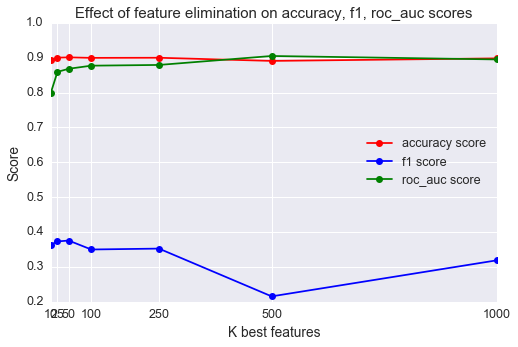

In [26]:
param_dist = {"randomforestclassifier__n_estimators": sp_randint(10,101),
              "randomforestclassifier__criterion": ["gini", "entropy"],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']}
rf_args = {'random_state':33}
n_features_list = [10,25,50,100,250,500,1000]
rf_clf = tuned_estimators(RandomForestClassifier,X_train.as_matrix(),y_train.as_matrix(),X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=6,scoring_method='roc_auc',verbose=True,**rf_args)

In [28]:
rf_clf.keys()

dict_keys(['clf_k100', 'clf_k500', 'clf_k25', 'clf_k1000', 'clf_k10', 'clf_k50', 'clf_k250'])

The random forest model with 50 best features had the best performance. The following provides the `confusion matrix`, `classification report` and `ROC curve` for `clf_k50`.

In [30]:
Summary_Results(rf_clf['clf_k50'],X_test.as_matrix(),y_test.as_matrix())

The accuracy is: 0.903 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15893 	 109
values 1:  	 1700 	 544
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.90      0.99      0.95     16002
    class 1       0.83      0.24      0.38      2244

avg / total       0.89      0.90      0.88     18246



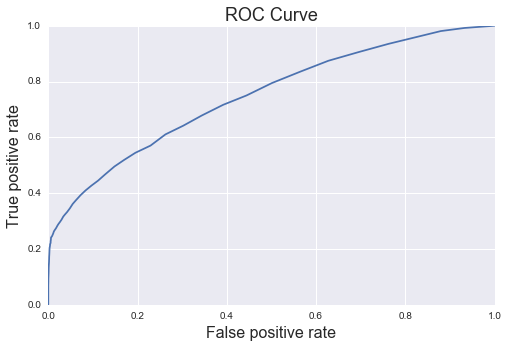

In [36]:
plot_roc_curve(rf_clf['clf_k50'],X_test.as_matrix(),y_test.as_matrix())

Best validation score: 0.7395


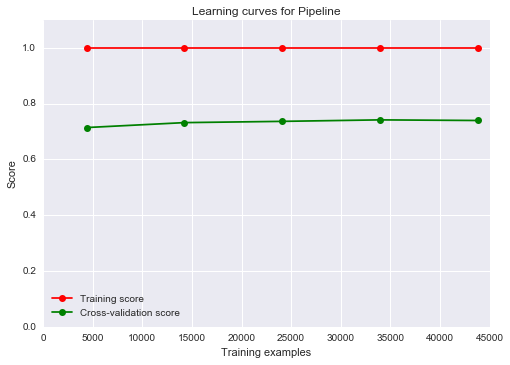

In [33]:
plot_learning_curve(rf_clf['clf_k50'], X_train.as_matrix(), y_train.as_matrix(), scoring='roc_auc')

### AdaBoost

10 best features: accuracy=0.8938, f1=0.3400, roc_auc=0.8114
25 best features: accuracy=0.8948, f1=0.3532, roc_auc=0.8133
50 best features: accuracy=0.8942, f1=0.3453, roc_auc=0.8121
100 best features: accuracy=0.8944, f1=0.3498, roc_auc=0.8115
250 best features: accuracy=0.8948, f1=0.3483, roc_auc=0.8161
500 best features: accuracy=0.8944, f1=0.3458, roc_auc=0.8141
1000 best features: accuracy=0.8950, f1=0.3541, roc_auc=0.8150


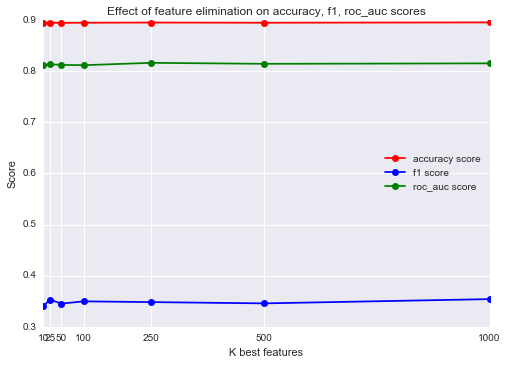

In [46]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_args = {'random_state':33}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001,0.001,0.01,0.1,1.0,2.0]}

n_features_list = [10,25,50,100,250,500,1000]
adb_clf = tuned_estimators(AdaBoostClassifier,X_train.as_matrix(),y_train.as_matrix(),X_test.as_matrix(),y_test.as_matrix()
                           ,param_dist,n_features_list,ncv=5,njobs=6,scoring_method='roc_auc',verbose=True,**adaboost_args)

### Few suggestions  to improve the performance:

1. Obviously, the performance of the trained classifier is not great as predicting all classes as the majority class would lead to 87% accuracy. In the learning curve, it can be seen that the training score is almost always 1.0 for all sample sizes. Hence, the classifier appears to be fairly complex. If I had more time, I would have tried other classification techniques. It is likely that other classification techniques provide a better performance on this dataset. For instance, a well tuned adaptive boosting estimator or support vector classifier (SVC). The SVC in sklearn has a `class_weight` parameter in the estimator and a `sample_weight` parameter in the fit method that can be used to improve the performance of SVC for imbalanced datasets.  

2. As we observed in the plots, some features did not seem to have a strong correlation with the targets. A better feature engineering may help to train more efficient estimators. For instance, there are a lot of data in `Model` and `SubModel` that can be extracted and used as separate features. Furthermore, it seems that some of the data were wrong or ambiguous. For instance, similar Trim, or SubModel data of a specific type of vehicle were imported in different forms that need to be revisited. 

3. Data imputation could be done more effectively. In several occasions, I had to use 'unknown' or 'NOT AVAIL' to impute missing values. Since we are dealing with a vehicle dataset, it is possible to find accurate information about some of the missing values. In addition, more effective imputing techniques (e.g. KNN imputer) could be used to fill in the missing values of some features. There is a `fancy impute` package in python that can be used for this purpose. Alternatively, R has a more variety of imputing packages that can be exploited for a richer imputing.

4. The dataset was imbalanced. Occasionally, over-sampling of the rare class or down-sampling of the majority class can help to improve the performance. The `unbalanced_dataset` python package offers a variety of methods to over/down-sample the dataset.

5. The smaller number of k-best models reduced the noise in the data. A finer grid search on the number of best features could improve the accuracy of the model. Alternatively, an effective feature selection method such as recursive feature elimination (REF or REFCV) can be used. 
